# Send custom emails to leads with Machine Learning
### Capstone project - Machine Learning Engineer Nanodegree

# 1. Definition

## 1.1 Project Overview

I am the founder of a digital agency called DeepIdea Lab. The services we offer are website creation, digital marketing, and graphic design. We have a partner who is sending us leads. The lead details include a description of the project each lead is looking for. This data is automatically pushed into our CRM. The next step is to send an email to the lead using one of our templates depending on the project’s description. However, we would like to automate this part. This is the topic of this capstone project: using machine learning to send a custom email to the lead based on the project’s description.

## 1.2. Problem Statement
Sending a manually composed email to every lead is time-consuming. We already have a few email templates available to be sent. However, so far, someone needs to read the project description in order to choose the right template. This is a typical natural language processing problem.

![Workflow-overview](./img/workflow-overview.png)

## 1.3 Metrics
Based on the dataset we have, a decent evaluation metrics would be the accuracy of the trained model on the test data. We will get new project descriptions from new leads so the accuracy on test data is a good metric.

# 2. Analysis

## 2.1 Gathering data

Here are the first steps to gather the data and create a dataset.

* CRM connection settings
* Check the format of the data from the API and explore the content
* Create the dataset

In [1]:
# import the required modules
import requests, json
import re
import pandas as pd
import numpy as np

### CRM connection settings

This is the configuration to connect to the API.

In [2]:
# enter your token, domain and view id in config.json.example and rename to config.json
with open('config.json', 'r') as f:
    config = json.load(f)

api_token = config['CONFIG']['TOKEN']
domain = config['CONFIG']['FRESHSALES_DOMAIN']
view_id = config['CONFIG']['VIEW_ID']

In [3]:
# define a function to connect to the Freshsales CRM API
def api_call(api_token = api_token, domain = domain, view_id = view_id, page_id_index = 1):
    api_url_base = 'https://{}.freshsales.io/api/'.format(domain)
    api_lead_request = 'leads/view/{}?page={}'.format(view_id, page_id_index)
    api_url = api_url_base + api_lead_request
    headers = {'Content-Type': 'application/json',
               'Authorization': 'Token token={0}'.format(api_token)}
    response = requests.get(api_url, headers=headers)
    data = response.json()
    
    return data

### Check the format of the data from the API and explore the content

Below we navigate through the result of the CRM's API to see the format we get.

In [4]:
# explore the data
data = api_call()

# data = json.dumps(data, indent=2)

print (data['leads'][22]['recent_note'])

Budget: 6000

Title: Création d'entreprise

Projet de création site web e-commerce pour  commercialiser.
Je souhaiterais une étude tarifaire, mais si possible une maquette et avoir des informations dans les compétences suivantes:
 - technique (catalogue en ligne, gestion du panier client, gestion des comptes clients, paiements en ligne…),
- partie graphique (logo, design, éléments graphiques…),
- aspects juridiques (mentions obligatoires, protection des données, conditions générales de vente et d’utilisation…,
- maintenance du site et connaître la réactivité en cas de problème.

Time limit: 6month




In [5]:
# function to loop over all the leads and extract the notes
def get_leads_notes():

    leads_id = []
    leads_note = []

    # for every page of leads
    for i in range(api_call()['meta']['total_pages']):
        page_index = i + 1
        data = api_call(page_id_index = page_index)

        # for every lead on the page
        for i in range(len(data['leads'])):

            lead_id = data['leads'][i]['id']
            lead_note = data['leads'][i]['recent_note']

            if lead_note:
                # drop urls
                pattern = r'https?:\/\/(www\.)?[-a-zA-Z0-9@:%._\+~#=] \
                {1,256}\.[a-zA-Z0-9()]{1,6}\b([-a-zA-Z0-9()@:%_\+.~#?&//=]*)'
                match = re.match(pattern, lead_note)
                if match:
                    lead_note = None

            if lead_note:
                leads_id.append(lead_id)
                leads_note.append(lead_note)
                
    return leads_id, leads_note

### Create the dataset

We create a DataFrame with all the project descriptions from the leads.

In [6]:
leads_id, leads_note = get_leads_notes()

leads_data = pd.DataFrame(data={'id': leads_id, 'note': leads_note})

In [7]:
leads_data.head()

,id,note
0,8011121189,Budget: 300\n\nTitle: Sito per pizzeria\n\nBuo...
1,8011389943,Budget: 5000\n\nTitle: Espace membre sécurisé ...
2,8011538684,Budget: 500\n\nTitle: Migration d'un nouveau s...
3,8009863335,Budget: 1\n\nTitle: request for a quotation to...
4,8010613505,Budget: 1000\n\nTitle: Mise à jour site web\n\...


In [8]:
# see a sample of the data
data_sample = leads_data.iloc[50,1]
print(data_sample)

Budget: 50

Title: Création site internet photographe

Je viens de crée un site internet avec wordpress et le thème Enfold. Je souhaiterai crée des galeries photos avec la possibilité de les commander en ligne directement.
Par exemple : En ouvrant un album, nous voyons toutes les photos et sur chaque photos, nous pouvons cliquer sur panier et choisir le format désiré.

Time limit: as_soon_as_possible




## 2.2 Data pre-processing

The raw data is not ready to be sent to an estimator yet. We need to process the data as follows:

* Cleaning of the data
* Export to CSV for labeling
* Import the labeled CSV
* Reduce the number of classes
* Detect the language of the text
* Keep only French text
* Tokenization
* Bag-of-Words features
* Save the processed training dataset locally


### Cleaning the data

In [9]:
def cleaning_data(data, symbols = False):
    data = re.sub(r'([a-zA-Z0-9_.+-]+@[a-zA-Z0-9-]+\.[a-zA-Z0-9-.]+)', '', data) # Remove email
    data = data.replace('\r', '').replace('\n', ' ').replace('  ', ' ')
    data = re.sub(r'Budget: .* Title: ', '', data) # Remove "Budget" 
    data = re.sub(r' Time limit: .*', '', data) # Remove "Time limit"
    data = re.sub(r'  +', ' ', data) # Remove extra space
    
    if symbols == False:
        data = re.sub(r"[^a-zA-ZÀ-ÿ]", " ", data.lower()) # Remove symbols and convert to lower case

    return data

In [10]:
# explore a sample of the data after cleaning
# but keep the symbols (easier to read the text for labeling)

print(cleaning_data(data_sample, symbols = True))

Création site internet photographe Je viens de crée un site internet avec wordpress et le thème Enfold. Je souhaiterai crée des galeries photos avec la possibilité de les commander en ligne directement. Par exemple : En ouvrant un album, nous voyons toutes les photos et sur chaque photos, nous pouvons cliquer sur panier et choisir le format désiré.


In [11]:
r, c = leads_data.shape
print("There are {} rows and {} columns before cleaning the dataset.".format(r, c))

# drop if row is missing data
clean_leads_data = leads_data.dropna()
r, c = clean_leads_data.shape
print("There are {} rows and {} columns after dropping missing value in the dataset.".format(r, c))

data = clean_leads_data
data.head()

There are 86 rows and 2 columns before cleaning the dataset.
There are 86 rows and 2 columns after dropping missing value in the dataset.


,id,note
0,8011121189,Budget: 300\n\nTitle: Sito per pizzeria\n\nBuo...
1,8011389943,Budget: 5000\n\nTitle: Espace membre sécurisé ...
2,8011538684,Budget: 500\n\nTitle: Migration d'un nouveau s...
3,8009863335,Budget: 1\n\nTitle: request for a quotation to...
4,8010613505,Budget: 1000\n\nTitle: Mise à jour site web\n\...


In [12]:
data_for_labeling = clean_leads_data

for index, row in data_for_labeling.iterrows():
    data_for_labeling.iloc[index, 1] = cleaning_data(row['note'], symbols = True)
    
data_for_labeling.head()

,id,note
0,8011121189,Sito per pizzeria Buongiorno un sito semplice ...
1,8011389943,Espace membre sécurisé et moteur de recherche ...
2,8011538684,Migration d'un nouveau site Jimdo à la place d...
3,8009863335,request for a quotation to re design a website...
4,8010613505,"Mise à jour site web Bonjour, Suite à une rési..."


### Export to CSV for labeling

We wil export the dataset to a CSV file so we can manually label each entry with the correct category. 

In [13]:
import os

data_dir = './data' # The folder we will use for storing data
if not os.path.exists(data_dir): # Make sure that the folder exists
    os.makedirs(data_dir)

data_for_labeling.to_csv(os.path.join(data_dir, 'leads.csv'), header=False, index=False)

After exporting the CSV, the database has been manually labeled with a spreadsheet and has been converted again to a new CSV file.

### Import the labeled CSV

In [110]:
# add the name of columns
column_names = []
for column in data_for_labeling.columns:
    column_names.append(column)
column_names.append('category')

labeled_leads = pd.read_csv(os.path.join(data_dir, 'labeled_leads.csv'), header=None, names=column_names)

labeled_leads.head(5)

,id,note,category
0,8011121189,Sito per pizzeria Buongiorno un sito semplice ...,website
1,8011389943,Espace membre sécurisé et moteur de recherche ...,website
2,8011538684,Migration d'un nouveau site Jimdo à la place d...,website
3,8009863335,request for a quotation to re design a website...,website
4,8010613505,"Mise à jour site web Bonjour, Suite à une rési...",website


It is important to see if the number of values in each category is more or less equal. Otherwise it will create a bias during the training.

In [111]:
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt

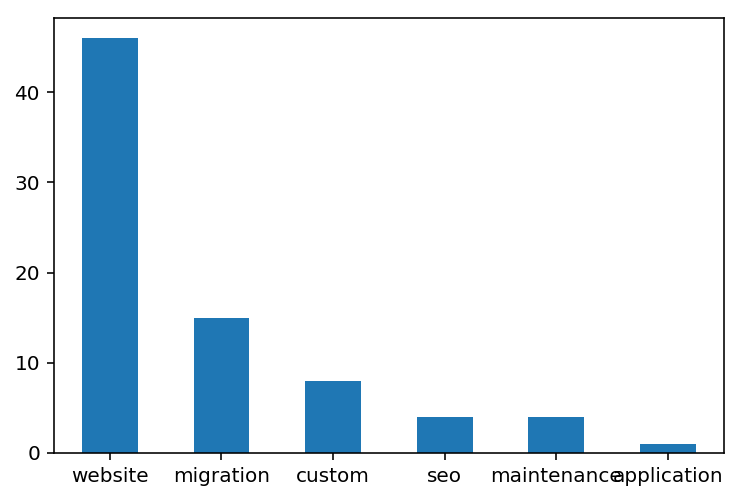

In [112]:
# see the distribution of the data
labeled_leads['category'].value_counts().plot(kind='bar', rot=0);

As we can see the category 'website' is much bigger than all the others.
In order to create better prediction without overfitting we need to make the entries in each category more even.

Let's create new categories as follows:
* website
* maintenance + seo
* migration
* custom + application

Note that we should also check the language of the project description. We will do that later.

### Reduce the number of classes

We reduce the number of categories to 4 (instead of 6 appearing in the labeled CSV).

In [113]:
category_bundle = {'website' : 0,
                   'maintenance' : 1,
                   'seo' : 1,
                   'migration' : 2,
                   'custom' : 3,
                   'application' : 3}

In [114]:
for index, row in labeled_leads.iterrows():
    labeled_leads.iloc[index, 2] = category_bundle[row['category']]

0    46
2    15
3     9
1     8
Name: category, dtype: int64


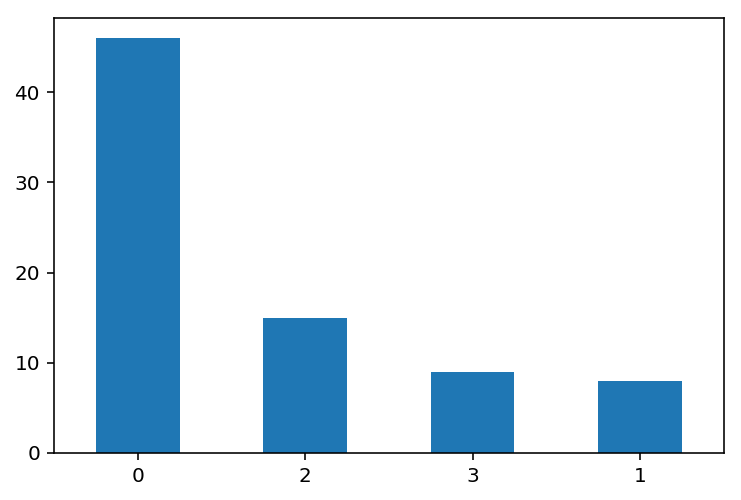

In [115]:
print(labeled_leads['category'].value_counts())
labeled_leads['category'].value_counts().plot(kind='bar', rot=0);

The distribution of the data is a bit better now since we bundle the categories together.
Let's see below an extract of our new dataset with the new categories.

In [116]:
labeled_leads.head(10)

,id,note,category
0,8011121189,Sito per pizzeria Buongiorno un sito semplice ...,0
1,8011389943,Espace membre sécurisé et moteur de recherche ...,0
2,8011538684,Migration d'un nouveau site Jimdo à la place d...,0
3,8009863335,request for a quotation to re design a website...,0
4,8010613505,"Mise à jour site web Bonjour, Suite à une rési...",0
5,8009584580,Mise à jour d'un site internet sous WordPress ...,0
6,8010414743,- la boutique sans plastique site web de vent...,0
7,8009725719,Fondation Site internet relativement simple. ...,0
8,8009572001,MIGRATION J'ai conçu un nouveau site internet ...,2
9,8009816679,Transfert hébergeur OVH vers Infomaniak Bonjou...,2


### Detect the language of the text

Next step of the data cleaning is to verify if the data is only in one language and if not we only keep the main language for training.

To do so we use the module langdetect.

In [117]:
!pip install langdetect

You are using pip version 10.0.1, however version 20.0.2 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [118]:
from langdetect import detect

lang_iso = {"ar" : "arabic",
            "da" : "danish",
            "nl" : "dutch",
            "en" : "english",
            "fi" : "finnish",
            "fr" : "french",
            "de" : "german",
            "hu" : "hungarian",
            "it" : "italian",
            "no" : "norwegian",
            "pt" : "portuguese",
            "ro" : "romanian",
            "ru" : "russian",
            "es" : "spanish",
            "sv" : "swedish"}

In [119]:
labeled_leads['lang'] = np.nan
for index in range(labeled_leads.shape[0]):
    labeled_leads.loc[index, 'lang'] = lang_iso[detect(labeled_leads.loc[index, 'note'])]

labeled_leads.head()

,id,note,category,lang
0,8011121189,Sito per pizzeria Buongiorno un sito semplice ...,0,italian
1,8011389943,Espace membre sécurisé et moteur de recherche ...,0,french
2,8011538684,Migration d'un nouveau site Jimdo à la place d...,0,french
3,8009863335,request for a quotation to re design a website...,0,english
4,8010613505,"Mise à jour site web Bonjour, Suite à une rési...",0,french


french     70
english     4
italian     2
german      2
Name: lang, dtype: int64


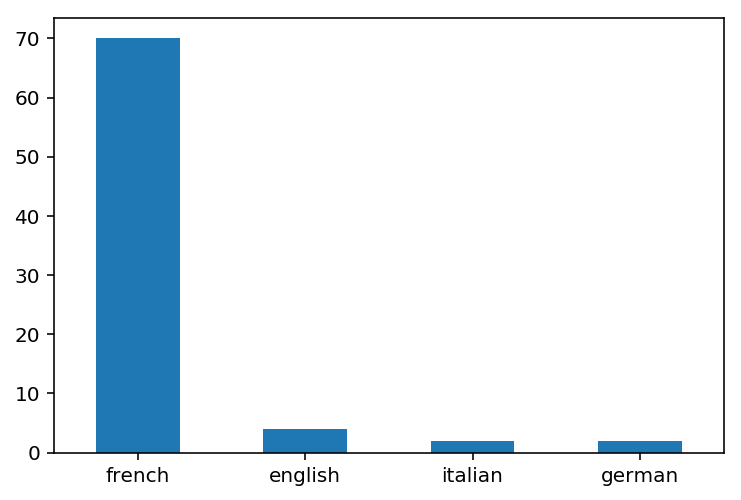

In [120]:
print(labeled_leads['lang'].value_counts())
labeled_leads['lang'].value_counts().plot(kind='bar', rot=0);

We see that the main language is French. To do our training we will drop the other languages.

### Keep only French text

In [121]:
# we keep only french text
indexNames = labeled_leads[labeled_leads['lang'] != 'french'].index
labeled_leads.drop(indexNames , inplace=True)

print(labeled_leads['lang'].value_counts())

#labeled_leads.head()

french    70
Name: lang, dtype: int64


In [122]:
# drop columns we don't need anymore
labeled_leads_out = labeled_leads[['category', 'note']].copy()
labeled_leads_out.head()

,category,note
1,0,Espace membre sécurisé et moteur de recherche ...
2,0,Migration d'un nouveau site Jimdo à la place d...
4,0,"Mise à jour site web Bonjour, Suite à une rési..."
5,0,Mise à jour d'un site internet sous WordPress ...
6,0,- la boutique sans plastique site web de vent...


Now that we have a clean dataset with labeled classes, we can process the text.

### Tokenization

It's pretty difficult for a ML algorithm to process raw texts.

So the method we are using is creating tokens from words in the text.

In [123]:
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import *

def lead_note_to_words(note):
    nltk.download("stopwords", quiet=True)
    stemmer = PorterStemmer()
    
    data = cleaning_data(note) # Clean the text
    lang = lang_iso[detect(data)] # Detect the language of the text
    words = data.split() # Split string into words

    words = [w for w in words if w not in stopwords.words(lang)] # Remove stopwords
    words = [PorterStemmer().stem(w) for w in words] # stem

    return words

In [124]:
# remove the name of the columns
labeled_leads_out.to_csv(os.path.join(data_dir, 'labeled_leads_out.csv'), header=False, index=False)
data = pd.read_csv(os.path.join(data_dir, 'labeled_leads_out.csv'))
data_values = data.values

In [125]:
# labels in the 1st column
data_y = data_values[:, 0]

# data in the 2nd column
data_X = [lead_note_to_words(note) for note in data_values[:, 1]]

print('See below an example of the tokens\n')
print(data_X[0])

See below an example of the tokens

['migrat', 'nouveau', 'site', 'jimdo', 'place', 'ancien', 'récupérat', 'adress', 'mail', 'bonjour', 'indépend', 'immobili', 'depui', 'an', 'depui', 'quelqu', 'moi', 'site', 'fonctionn', 'plu', 'copin', 'a', 'fait', 'gabarit', 'nouveau', 'site', 'jimdo', 'a', 'dû', 'partir', 'étranger', 'sort', 'fair', 'switcher', 'tout', 'cela', 'mainten', 'essayé', 'aussi', 'comprend', 'rien', 'dn', 'domain', 'registr', 'hébergeur', 'chinoi', 'sai', 'just', 'eurodn', 'code', 'jimdo', 'etc']


In [126]:
for i in range(len(data_X)):
    data_X[i] = ' '.join([str(elem) for elem in data_X[i]]) 

In [127]:
print('See below the same example after concatenate the tokens together again:\n')
print(data_X[0])

See below the same example after concatenate the tokens together again:

migrat nouveau site jimdo place ancien récupérat adress mail bonjour indépend immobili depui an depui quelqu moi site fonctionn plu copin a fait gabarit nouveau site jimdo a dû partir étranger sort fair switcher tout cela mainten essayé aussi comprend rien dn domain registr hébergeur chinoi sai just eurodn code jimdo etc


### Bag-of-Words features

We will now use the Bag-of-Words method. Learn more about that on [Wikipedia](https://en.wikipedia.org/wiki/Bag-of-words_model).

In [128]:
from sklearn.feature_extraction.text import CountVectorizer

def extract_BoW_features(words_train, words_test, vocabulary_size=40):
    """Extract Bag-of-Words for a given set of documents, already preprocessed into words."""
    
    # Fit a vectorizer to training documents and use it to transform them
    vectorizer = CountVectorizer(max_features=vocabulary_size)
    features_train = vectorizer.fit_transform(words_train).toarray()

    # Apply the same vectorizer to transform the test documents (ignore unknown words)
    features_test = vectorizer.transform(words_test).toarray()
    
    vocabulary = vectorizer.vocabulary_
    
    # Return both the extracted features as well as the vocabulary
    return features_train, features_test, vocabulary

In [129]:
from sklearn.model_selection import train_test_split

train_X, test_X, train_y, test_y = train_test_split(data_X, data_y, test_size=0.15, random_state=42)

In [130]:
# Extract Bag-of-Words features for both training and test datasets
train_X, test_X, vocabulary = extract_BoW_features(train_X, test_X)

In [131]:
print(vocabulary)

{'création': 8, 'site': 34, 'web': 37, 'actuel': 0, 'bonjour': 5, 'créer': 9, 'chez': 6, 'plu': 29, 'import': 19, 'lign': 24, 'besoin': 4, 'être': 39, 'sou': 35, 'gestion': 16, 'tout': 36, 'migrat': 26, 'internet': 21, 'afin': 1, 'fair': 14, 'lien': 23, 'serveur': 32, 'infomaniak': 20, 'wordpress': 38, 'page': 28, 'pouvoir': 30, 'merci': 25, 'mise': 27, 'jour': 22, 'base': 3, 'doit': 10, 'fichier': 15, 'si': 33, 'hébergement': 18, 'domain': 11, 'recherch': 31, 'donné': 12, 'avoir': 2, 'contenu': 7, 'email': 13, 'http': 17}


In [132]:
print('See below an example of the encoded bag-of-Words\n')

print(train_X[0][0:300])

See below an example of the encoded bag-of-Words

[2 0 0 0 1 1 2 0 2 1 0 0 0 0 0 0 1 0 0 1 0 0 0 0 2 0 0 0 0 1 0 0 0 0 2 1 1
 2 0 1]


In [133]:
# Then we split the training set further into training and validation sets.
train_X, val_X, train_y, val_y = train_test_split(train_X, train_y, test_size=0.2, random_state=42)

In [134]:
print('The training dataset has {} notes with {} labels.'.format(len(train_X), len(train_y)))
print('The validation dataset has {} notes with {} labels.'.format(len(val_X), len(val_y)))
print('The test dataset has {} notes with {} labels.'.format(len(test_X), len(test_y)))

The training dataset has 46 notes with 46 labels.
The validation dataset has 12 notes with 12 labels.
The test dataset has 11 notes with 11 labels.


### Save the processed training dataset locally

We export the CSV files ready for training locally.

In [135]:
pd.DataFrame(test_X).to_csv(os.path.join(data_dir, 'test.csv'), header=False, index=False)

pd.concat([pd.DataFrame(val_y), pd.DataFrame(val_X)], axis=1).to_csv(os.path.join(data_dir, 'val.csv'),
                                                                     header=False, index=False)
pd.concat([pd.DataFrame(train_y), pd.DataFrame(train_X)], axis=1).to_csv(os.path.join(data_dir, 'train.csv'),
                                                                         header=False, index=False)

## 2.3 Training and testing the model

We can now focus on training the model and check its accuracy.

* Uploading the training data
* XGBoost model
* Testing the model

### Uploading the training data

We need to upload the training data to the SageMaker default S3 bucket so that we can provide access to it while training our model.

In [136]:
import sagemaker
from sagemaker.amazon.amazon_estimator import get_image_uri

session = sagemaker.Session()

bucket = session.default_bucket()
prefix = 'lead_nlp_automation'

role = sagemaker.get_execution_role()

In [137]:
test_location = session.upload_data(os.path.join(data_dir, 'test.csv'), key_prefix=prefix)
val_location = session.upload_data(os.path.join(data_dir, 'val.csv'), key_prefix=prefix)
train_location = session.upload_data(os.path.join(data_dir, 'train.csv'), key_prefix=prefix)

### XGBoost model

It's the XGBoost model that has been chosen. XGBoost outperforms several other well-known implementations of gradient tree boosting (Pafka, 2015).

Let's create the xgb estimator first.

In [138]:
# As stated above, we use this utility method to construct the image name for the training container.
container = get_image_uri(session.boto_region_name, 'xgboost', '0.90-1')

# Now that we know which container to use, we can construct the estimator object.
xgb = sagemaker.estimator.Estimator(container, # The image name of the training container
                                    role,      # The IAM role to use (our current role in this case)
                                    train_instance_count=1, # The number of instances to use for training
                                    train_instance_type='ml.m4.xlarge', # The type of instance to use for training
                                    output_path='s3://{}/{}/output'.format(session.default_bucket(), prefix),
                                                                    # Where to save the output (the model artifacts)
                                    sagemaker_session=session) # The current SageMaker session

Here we set the hyperparameters for training.

In [139]:
xgb.set_hyperparameters(max_depth=10,
                        eta=0.42,
                        gamma=0,
                        min_child_weight=2,
                        subsample=0.87,
                        objective='multi:softmax',
                        early_stopping_rounds=10,
                        num_round=200,
                        num_class=4)

In [140]:
# This is a wrapper around the location of our train and validation data,
# to make sure that SageMakerknows our data is in csv format.
s3_input_train = sagemaker.s3_input(s3_data=train_location, content_type='csv')
s3_input_validation = sagemaker.s3_input(s3_data=val_location, content_type='csv')

In [141]:
xgb.fit({'train': s3_input_train, 'validation': s3_input_validation})

2020-03-29 03:10:59 Starting - Starting the training job...
2020-03-29 03:11:00 Starting - Launching requested ML instances...
2020-03-29 03:11:58 Starting - Preparing the instances for training......
2020-03-29 03:12:52 Downloading - Downloading input data...
2020-03-29 03:13:09 Training - Downloading the training image..INFO:sagemaker-containers:Imported framework sagemaker_xgboost_container.training
INFO:sagemaker-containers:Failed to parse hyperparameter objective value multi:softmax to Json.
Returning the value itself
INFO:sagemaker-containers:No GPUs detected (normal if no gpus installed)
INFO:sagemaker_xgboost_container.training:Running XGBoost Sagemaker in algorithm mode
INFO:root:Determined delimiter of CSV input is ','
INFO:root:Determined delimiter of CSV input is ','
INFO:root:Determined delimiter of CSV input is ','
[03:13:43] 46x40 matrix with 1840 entries loaded from /opt/ml/input/data/train?format=csv&label_column=0&delimiter=,
INFO:root:Determined delimiter of CSV inpu

### Testing the model

Now that we have fitted our model to the training data, using the validation data to avoid overfitting, we can test our model. To do this we will make use of SageMaker's Batch Transform functionality. To start with, we need to build a transformer object from our fit model.

In [142]:
xgb_transformer = xgb.transformer(instance_count = 1, instance_type = 'ml.m4.xlarge')

In [143]:
xgb_transformer.transform(test_location, content_type='text/csv', split_type='Line')

In [144]:
xgb_transformer.wait()

.....................
[2020-03-29 03:17:32 +0000] [15] [INFO] Starting gunicorn 19.10.0
[2020-03-29 03:17:32 +0000] [15] [INFO] Listening at: unix:/tmp/gunicorn.sock (15)
[2020-03-29 03:17:32 +0000] [15] [INFO] Using worker: gevent
[2020-03-29 03:17:32 +0000] [22] [INFO] Booting worker with pid: 22
[2020-03-29 03:17:32 +0000] [23] [INFO] Booting worker with pid: 23
[2020-03-29 03:17:32 +0000] [27] [INFO] Booting worker with pid: 27
[2020-03-29 03:17:32 +0000] [31] [INFO] Booting worker with pid: 31
[2020-03-29:03:17:37:INFO] No GPUs detected (normal if no gpus installed)
169.254.255.130 - - [29/Mar/2020:03:17:37 +0000] "GET /ping HTTP/1.1" 200 0 "-" "Go-http-client/1.1"
169.254.255.130 - - [29/Mar/2020:03:17:37 +0000] "GET /execution-parameters HTTP/1.1" 200 84 "-" "Go-http-client/1.1"
[2020-03-29:03:17:37:INFO] Determined delimiter of CSV input is ','
169.254.255.130 - - [29/Mar/2020:03:17:37 +0000] "POST /invocations HTTP/1.1" 200 44 "-" "Go-http-client/1.1"
2020-03-29T03:17:37.751:[

In [145]:
!aws s3 cp --recursive $xgb_transformer.output_path $data_dir

download: s3://sagemaker-eu-west-1-384935747368/sagemaker-xgboost-2020-03-29-03-14-11-704/test.csv.out to data/test.csv.out


In [146]:
pred_y = pd.read_csv(os.path.join(data_dir, 'test.csv.out'), header=None)

Let's check below the accuracy of the model.

In [147]:
from sklearn.metrics import accuracy_score

ground = test_y.astype(int)
results = pred_y.values.flatten().astype(int)

accuracy_score(ground, results)

0.45454545454545453

In [148]:
## print out the array of predicted and true labels
print('\nPredicted class labels: ')
print(results)
print('\nTrue class labels: ')
print(ground)


Predicted class labels: 
[1 0 3 2 2 0 0 0 3 0 0]

True class labels: 
[0 0 3 0 1 1 0 2 0 0 0]


As we have a very small dataset it is interesting to check if the data of the validation set is well mixed.

In [149]:
# check if the validation dataset is mixed
print('\nValidation class labels: ')
print(val_y.astype(int))


Validation class labels: 
[3 0 0 3 0 0 0 0 0 2 1 0]


## 2.4 Tuning the Hyperparameters

* Hyperparameter Tuner
* Testing the model

### Hyperparameter Tuner

Let's try to launch a hyperparameters' tuning job to see if it can improve our model's performance.

In [54]:
from sagemaker.tuner import IntegerParameter, ContinuousParameter, HyperparameterTuner

xgb_hyperparameter_tuner = HyperparameterTuner(estimator = xgb, # The estimator object to use as the basis
                                               objective_metric_name = 'validation:merror', # The metric to compare
                                               objective_type = 'Minimize', # Minimize or maximize the metric
                                               max_jobs = 20, # The total number of models to train
                                               max_parallel_jobs = 3, # The number of models to train in parallel
                                               hyperparameter_ranges = {
                                                    'max_depth': IntegerParameter(3, 13),
                                                    'eta'      : ContinuousParameter(0.05, 0.6),
                                                    'min_child_weight': IntegerParameter(2, 8),
                                                    'subsample': ContinuousParameter(0.5, 0.9),
                                                    'gamma': ContinuousParameter(0, 10),
                                               })

In [55]:
xgb_hyperparameter_tuner.fit({'train': s3_input_train, 'validation': s3_input_validation})
xgb_hyperparameter_tuner.wait()

...................................................................................................................................................................................................................................................................................!


In [56]:
xgb_hyperparameter_tuner.best_training_job()

'sagemaker-xgboost-200329-0113-018-b6165286'

In [57]:
xgb_attached = sagemaker.estimator.Estimator.attach(xgb_hyperparameter_tuner.best_training_job())

2020-03-29 01:33:16 Starting - Preparing the instances for training
2020-03-29 01:33:16 Downloading - Downloading input data
2020-03-29 01:33:16 Training - Training image download completed. Training in progress.
2020-03-29 01:33:16 Uploading - Uploading generated training model
2020-03-29 01:33:16 Completed - Training job completedINFO:sagemaker-containers:Imported framework sagemaker_xgboost_container.training
INFO:sagemaker-containers:Failed to parse hyperparameter _tuning_objective_metric value validation:merror to Json.
Returning the value itself
INFO:sagemaker-containers:Failed to parse hyperparameter objective value multi:softmax to Json.
Returning the value itself
INFO:sagemaker-containers:No GPUs detected (normal if no gpus installed)
INFO:sagemaker_xgboost_container.training:Running XGBoost Sagemaker in algorithm mode
INFO:root:Determined delimiter of CSV input is ','
INFO:root:Determined delimiter of CSV input is ','
INFO:root:Determined delimiter of CSV input is ','
[01:33:

In [58]:
xgb_transformer = xgb_attached.transformer(instance_count = 1, instance_type = 'ml.m4.xlarge')

In [59]:
xgb_transformer.transform(test_location, content_type='text/csv', split_type='Line')
xgb_transformer.wait()

......................[2020-03-29 01:39:53 +0000] [14] [INFO] Starting gunicorn 19.10.0
[2020-03-29 01:39:53 +0000] [14] [INFO] Listening at: unix:/tmp/gunicorn.sock (14)
[2020-03-29 01:39:53 +0000] [14] [INFO] Using worker: gevent
[2020-03-29 01:39:53 +0000] [21] [INFO] Booting worker with pid: 21
[2020-03-29 01:39:53 +0000] [22] [INFO] Booting worker with pid: 22
[2020-03-29 01:39:53 +0000] [26] [INFO] Booting worker with pid: 26
[2020-03-29 01:39:53 +0000] [27] [INFO] Booting worker with pid: 27
[2020-03-29:01:40:15:INFO] No GPUs detected (normal if no gpus installed)
169.254.255.130 - - [29/Mar/2020:01:40:15 +0000] "GET /ping HTTP/1.1" 200 0 "-" "Go-http-client/1.1"
[2020-03-29:01:40:15:INFO] No GPUs detected (normal if no gpus installed)
169.254.255.130 - - [29/Mar/2020:01:40:15 +0000] "GET /ping HTTP/1.1" 200 0 "-" "Go-http-client/1.1"
[2020-03-29:01:40:15:INFO] No GPUs detected (normal if no gpus installed)
169.254.255.130 - - [29/Mar/2020:01:40:15 +0000] "GET /execution-paramet

In [60]:
!aws s3 cp --recursive $xgb_transformer.output_path $data_dir

download: s3://sagemaker-eu-west-1-384935747368/sagemaker-xgboost-200329-0113-018-b6165-2020-03-29-01-36-33-248/test.csv.out to data/test.csv.out


In [61]:
pred_y = pd.read_csv(os.path.join(data_dir, 'test.csv.out'), header=None)

### Testing the model

Let's discover now the accuracy of the best trained model below.

In [62]:
from sklearn.metrics import accuracy_score

ground = test_y.astype(int)
results = pred_y.values.flatten().astype(int)

accuracy_score(ground, results)

0.6363636363636364

In [63]:
## print out the array of predicted and true labels
print('\nPredicted class labels: ')
print(results)
print('\nTrue class labels: ')
print(ground)


Predicted class labels: 
[0 0 0 0 0 0 0 0 0 0 0]

True class labels: 
[0 0 3 0 1 1 0 2 0 0 0]


In [64]:
# check if the validation dataset is mixed
print('\nValidation class labels: ')
print(val_y.astype(int))


Validation class labels: 
[3 0 0 3 0 0 0 0 0 2 1 0]


## 2.5 Binary classification

* Two categories
* Training of the model
* Testing the model
* Tuning the Hyperparameters

### Two categories

The accuracy of the last model is 63%. Therefore it could be improved. The reason is probably because our dataset is very small. A way to improve the accuracy is to reduce the number of categories. Here we decide to reduce to 2 categories.

In [65]:
# convert class 1, 2, 3 to 1

for i in range(labeled_leads_out.shape[0]):
    if labeled_leads_out.iloc[i,0] != 0:
        labeled_leads_out.iloc[i,0] = 1

0    40
1    30
Name: category, dtype: int64


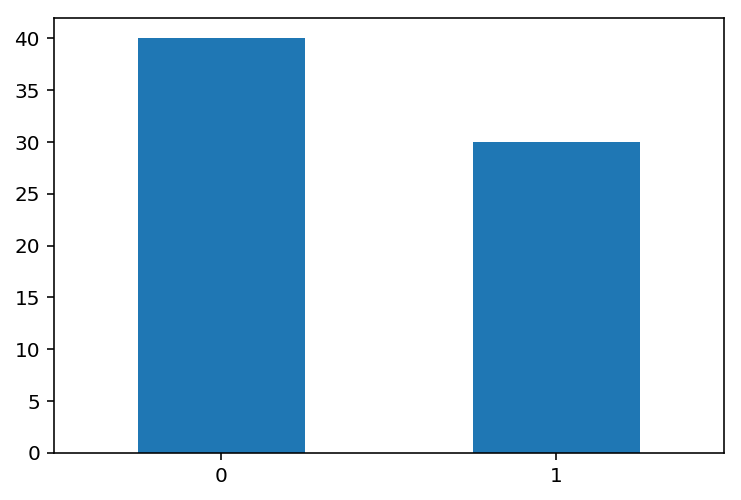

In [66]:
print(labeled_leads_out['category'].value_counts())
labeled_leads_out['category'].value_counts().plot(kind='bar', rot=0);

You can see above that now the number in each category is almost equal.

The steps below are the same as before but in a binary way.

In [67]:
# remove the name of the columns
labeled_leads_out.to_csv(os.path.join(data_dir, 'labeled_leads_out.csv'), header=False, index=False)
data = pd.read_csv(os.path.join(data_dir, 'labeled_leads_out.csv'))
data_values = data.values

In [68]:
# labels in the 1st column
data_y = data_values[:, 0]

# data in the 2nd column
data_X = [lead_note_to_words(note) for note in data_values[:, 1]]

for i in range(len(data_X)):
    data_X[i] = ' '.join([str(elem) for elem in data_X[i]]) 

In [69]:
train_X, test_X, train_y, test_y = train_test_split(data_X, data_y, test_size=0.2, random_state=42)

In [70]:
# Extract Bag of Words features for both training and test datasets
train_X, test_X, vocabulary = extract_BoW_features(train_X, test_X)

In [71]:
# Then we split the training set further into training and validation sets.
train_X, val_X, train_y, val_y = train_test_split(train_X, train_y, test_size=0.2, random_state=42)

In [72]:
print('The training dataset has {} notes with {} labels.'.format(len(train_X), len(train_y)))
print('The validation dataset has {} notes with {} labels.'.format(len(val_X), len(val_y)))
print('The test dataset has {} notes with {} labels.'.format(len(test_X), len(test_y)))

The training dataset has 44 notes with 44 labels.
The validation dataset has 11 notes with 11 labels.
The test dataset has 14 notes with 14 labels.


In [73]:
pd.DataFrame(test_X).to_csv(os.path.join(data_dir, 'test.csv'), header=False, index=False)

pd.concat([pd.DataFrame(val_y), pd.DataFrame(val_X)], axis=1).to_csv(os.path.join(data_dir, 'val.csv'),
                                                                     header=False, index=False)
pd.concat([pd.DataFrame(train_y), pd.DataFrame(train_X)], axis=1).to_csv(os.path.join(data_dir, 'train.csv'),
                                                                         header=False, index=False)

### Training of the model

We start again our training this time with the new binary labels.

In [74]:
test_location = session.upload_data(os.path.join(data_dir, 'test.csv'), key_prefix=prefix)
val_location = session.upload_data(os.path.join(data_dir, 'val.csv'), key_prefix=prefix)
train_location = session.upload_data(os.path.join(data_dir, 'train.csv'), key_prefix=prefix)

In [75]:
# As stated above, we use this utility method to construct the image name for the training container.
container = get_image_uri(session.boto_region_name, 'xgboost', '0.90-1')

# Now that we know which container to use, we can construct the estimator object.
xgb = sagemaker.estimator.Estimator(container, # The image name of the training container
                                    role,      # The IAM role to use (our current role in this case)
                                    train_instance_count=1, # The number of instances to use for training
                                    train_instance_type='ml.m4.xlarge', # The type of instance to use for training
                                    output_path='s3://{}/{}/output'.format(session.default_bucket(), prefix),
                                                                    # Where to save the output (the model artifacts)
                                    sagemaker_session=session) # The current SageMaker session

In [76]:
xgb.set_hyperparameters(max_depth=10,
                        eta=0.6,
                        gamma=0.01,
                        min_child_weight=5,
                        subsample=0.5,
                        objective='reg:squarederror',
                        early_stopping_rounds=10,
                        num_round=300)

In [77]:
# This is a wrapper around the location of our train and validation data, to make sure that SageMaker
# knows our data is in csv format.
s3_input_train = sagemaker.s3_input(s3_data=train_location, content_type='csv')
s3_input_validation = sagemaker.s3_input(s3_data=val_location, content_type='csv')

In [78]:
xgb.fit({'train': s3_input_train, 'validation': s3_input_validation})

2020-03-29 01:40:48 Starting - Starting the training job...
2020-03-29 01:40:49 Starting - Launching requested ML instances...
2020-03-29 01:41:46 Starting - Preparing the instances for training......
2020-03-29 01:42:36 Downloading - Downloading input data...
2020-03-29 01:42:53 Training - Downloading the training image..INFO:sagemaker-containers:Imported framework sagemaker_xgboost_container.training
INFO:sagemaker-containers:Failed to parse hyperparameter objective value reg:squarederror to Json.
Returning the value itself
INFO:sagemaker-containers:No GPUs detected (normal if no gpus installed)
INFO:sagemaker_xgboost_container.training:Running XGBoost Sagemaker in algorithm mode
INFO:root:Determined delimiter of CSV input is ','
INFO:root:Determined delimiter of CSV input is ','
INFO:root:Determined delimiter of CSV input is ','
[01:43:27] 44x40 matrix with 1760 entries loaded from /opt/ml/input/data/train?format=csv&label_column=0&delimiter=,
INFO:root:Determined delimiter of CSV i

### Testing the model

We test the new model accuracy.

In [79]:
xgb_transformer = xgb.transformer(instance_count = 1, instance_type = 'ml.m4.xlarge')

In [80]:
xgb_transformer.transform(test_location, content_type='text/csv', split_type='Line')

In [81]:
xgb_transformer.wait()

........................[2020-03-29 01:47:44 +0000] [15] [INFO] Starting gunicorn 19.10.0
[2020-03-29 01:47:44 +0000] [15] [INFO] Listening at: unix:/tmp/gunicorn.sock (15)
[2020-03-29 01:47:44 +0000] [15] [INFO] Using worker: gevent
[2020-03-29 01:47:44 +0000] [22] [INFO] Booting worker with pid: 22
[2020-03-29 01:47:44 +0000] [23] [INFO] Booting worker with pid: 23
[2020-03-29 01:47:44 +0000] [24] [INFO] Booting worker with pid: 24
[2020-03-29 01:47:44 +0000] [31] [INFO] Booting worker with pid: 31
[2020-03-29:01:48:05:INFO] No GPUs detected (normal if no gpus installed)
169.254.255.130 - - [29/Mar/2020:01:48:05 +0000] "GET /ping HTTP/1.1" 200 0 "-" "Go-http-client/1.1"
[2020-03-29:01:48:05:INFO] No GPUs detected (normal if no gpus installed)
169.254.255.130 - - [29/Mar/2020:01:48:05 +0000] "GET /execution-parameters HTTP/1.1" 200 84 "-" "Go-http-client/1.1"
[2020-03-29:01:48:05:INFO] Determined delimiter of CSV input is ','
169.254.255.130 - - [29/Mar/2020:01:48:05 +0000] "POST /inv

In [82]:
!aws s3 cp --recursive $xgb_transformer.output_path $data_dir

download: s3://sagemaker-eu-west-1-384935747368/sagemaker-xgboost-2020-03-29-01-44-00-182/test.csv.out to data/test.csv.out


In [83]:
pred_y = pd.read_csv(os.path.join(data_dir, 'test.csv.out'), header=None)

In [84]:
from sklearn.metrics import accuracy_score

ground = test_y.astype(int)
results = pred_y.values.flatten().astype(int)

accuracy_score(ground, results)

0.42857142857142855

In [85]:
## print out the array of predicted and true labels
print('\nPredicted class labels: ')
print(results)
print('\nTrue class labels: ')
print(ground)


Predicted class labels: 
[0 0 0 0 0 0 0 0 1 0 0 0 0 0]

True class labels: 
[0 0 1 0 1 1 0 1 0 0 0 1 1 1]


In [86]:
# check if the validation dataset is mixed
print('\nValidation class labels: ')
print(val_y.astype(int))


Validation class labels: 
[0 1 0 1 1 0 0 1 0 0 1]


### Tuning the Hyperparameters

Let's try to improve the hyperparameters of our new model.

In [87]:
from sagemaker.tuner import IntegerParameter, ContinuousParameter, HyperparameterTuner

xgb_hyperparameter_tuner = HyperparameterTuner(estimator = xgb, # The estimator object to use as the basis
                                               objective_metric_name = 'validation:rmse', # The metric used to compare
                                               objective_type = 'Minimize', # Minimize or maximize the metric
                                               max_jobs = 20, # The total number of models to train
                                               max_parallel_jobs = 3, # The number of models to train in parallel
                                               hyperparameter_ranges = {
                                                    'max_depth': IntegerParameter(3, 13),
                                                    'eta'      : ContinuousParameter(0.05, 0.6),
                                                    'min_child_weight': IntegerParameter(2, 8),
                                                    'subsample': ContinuousParameter(0.5, 0.9),
                                                    'gamma': ContinuousParameter(0, 10),
                                               })

In [88]:
xgb_hyperparameter_tuner.fit({'train': s3_input_train, 'validation': s3_input_validation})
xgb_hyperparameter_tuner.wait()

..................................................................................................................................................................................................................................................................................!


In [89]:
xgb_hyperparameter_tuner.best_training_job()

'sagemaker-xgboost-200329-0148-018-5e0343ac'

In [90]:
xgb_attached = sagemaker.estimator.Estimator.attach(xgb_hyperparameter_tuner.best_training_job())

2020-03-29 02:10:03 Starting - Preparing the instances for training
2020-03-29 02:10:03 Downloading - Downloading input data
2020-03-29 02:10:03 Training - Training image download completed. Training in progress.
2020-03-29 02:10:03 Uploading - Uploading generated training model
2020-03-29 02:10:03 Completed - Training job completedINFO:sagemaker-containers:Imported framework sagemaker_xgboost_container.training
INFO:sagemaker-containers:Failed to parse hyperparameter _tuning_objective_metric value validation:rmse to Json.
Returning the value itself
INFO:sagemaker-containers:Failed to parse hyperparameter objective value reg:squarederror to Json.
Returning the value itself
INFO:sagemaker-containers:No GPUs detected (normal if no gpus installed)
INFO:sagemaker_xgboost_container.training:Running XGBoost Sagemaker in algorithm mode
INFO:root:Determined delimiter of CSV input is ','
INFO:root:Determined delimiter of CSV input is ','
INFO:root:Determined delimiter of CSV input is ','
[02:09

In [91]:
xgb_transformer = xgb_attached.transformer(instance_count = 1, instance_type = 'ml.m4.xlarge')

In [92]:
xgb_transformer.transform(test_location, content_type='text/csv', split_type='Line')
xgb_transformer.wait()

.....................
.[2020-03-29 02:15:11 +0000] [15] [INFO] Starting gunicorn 19.10.0
[2020-03-29 02:15:11 +0000] [15] [INFO] Listening at: unix:/tmp/gunicorn.sock (15)
[2020-03-29 02:15:11 +0000] [15] [INFO] Using worker: gevent
[2020-03-29 02:15:11 +0000] [22] [INFO] Booting worker with pid: 22
[2020-03-29 02:15:11 +0000] [23] [INFO] Booting worker with pid: 23
[2020-03-29 02:15:11 +0000] [27] [INFO] Booting worker with pid: 27
[2020-03-29 02:15:11 +0000] [15] [INFO] Starting gunicorn 19.10.0
[2020-03-29 02:15:11 +0000] [15] [INFO] Listening at: unix:/tmp/gunicorn.sock (15)
[2020-03-29 02:15:11 +0000] [15] [INFO] Using worker: gevent
[2020-03-29 02:15:11 +0000] [22] [INFO] Booting worker with pid: 22
[2020-03-29 02:15:11 +0000] [23] [INFO] Booting worker with pid: 23
[2020-03-29 02:15:11 +0000] [27] [INFO] Booting worker with pid: 27
[2020-03-29 02:15:11 +0000] [31] [INFO] Booting worker with pid: 31
[2020-03-29 02:15:11 +0000] [31] [INFO] Booting worker with pid: 31
[2020-03-29:0

In [93]:
!aws s3 cp --recursive $xgb_transformer.output_path $data_dir

download: s3://sagemaker-eu-west-1-384935747368/sagemaker-xgboost-200329-0148-018-5e034-2020-03-29-02-11-47-612/test.csv.out to data/test.csv.out


In [94]:
pred_y = pd.read_csv(os.path.join(data_dir, 'test.csv.out'), header=None)

We can see below the accuracy after a hyperparameter tuning job of our new binary classification.

In [95]:
from sklearn.metrics import accuracy_score

ground = test_y.astype(int)
results = pred_y.values.flatten().astype(int)

accuracy_score(ground, results)

0.5

In [96]:
## print out the array of predicted and true labels
print('\nPredicted class labels: ')
print(results)
print('\nTrue class labels: ')
print(ground)


Predicted class labels: 
[0 0 0 0 0 0 0 0 0 0 0 0 0 0]

True class labels: 
[0 0 1 0 1 1 0 1 0 0 0 1 1 1]


In [97]:
# check if the validation dataset is mixed
print('\nValidation class labels: ')
print(val_y.astype(int))


Validation class labels: 
[0 1 0 1 1 0 0 1 0 0 1]


## 2.6 Deploy the model

We will deploy now an API endpoint with our favourite trained model.

In [150]:
# Deploy the trained model

xgb_predictor = xgb.deploy(initial_instance_count = 1, instance_type = 'ml.m4.xlarge')

-------------!

In [151]:
xgb_predictor.endpoint

'sagemaker-xgboost-2020-03-29-03-10-59-734'

In [152]:
from sagemaker.predictor import csv_serializer

# We need to tell the endpoint the format of the data we are sending
xgb_predictor.content_type = 'text/csv'
xgb_predictor.serializer = csv_serializer

pred_y = xgb_predictor.predict(pd.DataFrame(test_X).values).decode('utf-8')
# predictions is currently a comma delimited string and so we would like to break it up
# as a numpy array.
pred_y = np.fromstring(pred_y, sep=',')

In [153]:
from sklearn.metrics import accuracy_score
accuracy_score(test_y.astype('int'), pred_y.astype('int'))

0.45454545454545453

## 2.7 Web application

* Input testing
* AWS Lambda
* HTML web app

### Input testing

We will create now the web application that will format a new text and send to our model's API to predict the category.

The web application is a HTML file with some JS talking to the endpoint.

The code that formats the data is hosted on AWS Lambda. We need to place the vocabulary inside our lambda function as well.

First let's try a test input string to our endpoint.

In [102]:
vocab = {'création': 9, 'site': 33, 'web': 36, 'actuel': 0, 'bonjour': 4,
         'chez': 6, 'plu': 28, 'import': 18, 'lign': 23, 'besoin': 3, 'être': 39,
         'sou': 34, 'gestion': 15, 'tout': 35, 'migrat': 25, 'internet': 20,
         'afin': 1, 'fair': 13, 'lien': 22, 'serveur': 31, 'infomaniak': 19,
         'wordpress': 37, 'page': 27, 'pouvoir': 29, 'merci': 24, 'mise': 26,
         'jour': 21, 'base': 2, 'doit': 10, 'fichier': 14, 'si': 32,
         'hébergement': 17, 'domain': 11, 'recherch': 30, 'donné': 12, 'contenu': 8,
         'www': 38, 'ch': 5, 'com': 7, 'http': 16}

In [103]:
# Replace the content of test_X with any text you want to test
test_X = 'Hello, je me suis trompé de migration'
test_X = lead_note_to_words(test_X)
test_X = ' '.join([str(elem) for elem in test_X]) 

In [104]:
def bow_encoding(words, vocabulary):
    bow = [0] * len(vocabulary) # Start by setting the count for each word in the vocabulary to zero.
    for word in words.split():  # For each word in the string
        if word in vocabulary:  # If the word is one that occurs in the vocabulary, increase its count.
            bow[vocabulary[word]] += 1
    return bow

In [105]:
bow = bow_encoding(test_X, vocab)

In [106]:
endpoint_name = xgb_predictor.endpoint

In [107]:
response = session.sagemaker_runtime_client.invoke_endpoint(
                                                EndpointName = endpoint_name,
                                                ContentType = 'text/csv',
                                                Body = ','.join([str(val) for val in bow]).encode('utf-8'))

In [108]:
print(response['Body'].read().decode('utf-8'))

0.8204420208930969


### AWS Lambda

Below is the lambda function. Keep in mind to import the folder 'nltk' and 'nltk_data'.

You also need to tell Lambda where is the nltk_data folder by adding an environment variable.

```json
NLTK_DATA ./nltk_data
```

![AWS Lambda](./img/aws-environment-variables.png)

```python

import boto3
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import *
import json

def cleaning_data(data, symbols = False):
    data = re.sub(r'([a-zA-Z0-9_.+-]+@[a-zA-Z0-9-]+\.[a-zA-Z0-9-.]+)', '', data) # Remove email
    data = data.replace('\r', '').replace('\n', ' ').replace('  ', ' ')
    data = re.sub(r'Budget: .* Title: ', '', data) # Remove "Budget" 
    data = re.sub(r' Time limit: .*', '', data) # and "Time limit"
    data = re.sub(r'  +', ' ', data) # Remove extra space
    
    if symbols == False:
        data = re.sub(r"[^a-zA-ZÀ-ÿ]", " ", data.lower()) # Remove symbols and convert to lower case

    return data


def lead_note_to_words(note):
    # nltk.download("stopwords", quiet=True) # We already added the nltk_data folder manually
    stemmer = PorterStemmer()
    
    data = cleaning_data(note) # Clean the text
    words = data.split() # Split string into words

    words = [w for w in words if w not in stopwords.words('french')] # Remove stopwords
    words = [PorterStemmer().stem(w) for w in words] # stem

    return words
    

def bow_encoding(words, vocabulary):
    bow = [0] * len(vocabulary) # Start by setting the count for each word in the vocabulary to zero.
    for word in words.split():  # For each word in the string
        if word in vocabulary:  # If the word is one that occurs in the vocabulary, increase its count.
            bow[vocabulary[word]] += 1
    return bow


def lambda_handler(event, context):

    vocab = {'création': 9, 'site': 33, 'web': 36, 'actuel': 0, 'bonjour': 4,
    'chez': 6, 'plu': 28, 'import': 18, 'lign': 23, 'besoin': 3, 'être': 39,
    'sou': 34, 'gestion': 15, 'tout': 35, 'migrat': 25, 'internet': 20,
    'afin': 1, 'fair': 13, 'lien': 22, 'serveur': 31, 'infomaniak': 19,
    'wordpress': 37, 'page': 27, 'pouvoir': 29, 'merci': 24, 'mise': 26,
    'jour': 21, 'base': 2, 'doit': 10, 'fichier': 14, 'si': 32,
    'hébergement': 17, 'domain': 11, 'recherch': 30, 'donné': 12, 'contenu': 8,
    'www': 38, 'ch': 5, 'com': 7, 'http': 16}

    words = lead_note_to_words(event['body'])
    words = ' '.join([str(elem) for elem in words]) 
    bow = bow_encoding(words, vocab)

    # The SageMaker runtime is what allows us to invoke the endpoint that we've created.
    runtime = boto3.Session().client('sagemaker-runtime')

    # Now we use the SageMaker runtime to invoke our endpoint, sending the review we were given
    response = runtime.invoke_endpoint(EndpointName = 'sagemaker-xgboost-2020-03-28-20-51-47-434',
                                       # The name of the endpoint we created
                                       ContentType = 'text/csv',
                                       Body = ','.join([str(val) for val in bow]).encode('utf-8'))

    # The response is an HTTP response whose body contains the result of our inference
    result = response['Body'].read().decode('utf-8')

    return {
        'statusCode' : 200,
        'headers' : { 'Content-Type' : 'text/plain', 'Access-Control-Allow-Origin' : '*' },
        'body' : str(result)
    }

```

### HTML web app

To try the app, download the file index.html and open it in a browser.

It should look like that:

![web-app](./img/web-app.png)

Below an example of text you can try in the app:

>Je cherche une personne pour terminer mon site créé avec Opencard vu que la personne qui s'en occupait n'a pas fait les choses correctement, soit, CHF 1'500.- de perdu…
Ce site est un site d'information concernant des supports publicitaires (briquets, stylos, T-shirts, affiches publicitaires, etc…) avec demandes d'offres uniquement.
Photos et descriptifs (couleurs, dimensions, etc…) de chaque produit.
Formulaire de contact.
Créer une liste de partenaires avec lien vers leur site.

In [109]:
# when the endpoint is not needed anymore
xgb_predictor.delete_endpoint()

# 3. Conclusion

* 3.1 Reflection
* 3.2 Improvement

## 3.1 Reflection

The task seemed quite simple in the beginning but actually became much more difficult because of the small size of the dataset.

The key to find a good result was to figure out what were the best parameters for the following variables:

* Ratio training, validation and test dataset
* Size of Bag-of-Words' vocabulary
* Hyperparameters

The XGBoost model is working fine because we can see that the RMSE measure is decreasing towards the training set. In order to avoid overfitting we provide a validation set. However the model struggles to improve the RMSE of the validation set because of the small size of the dataset.

We decided to keep the multiclass trained model for our deployed endpoint API because compared to the binary classifier model it achieves higher accuracy.

## 3.2 Improvement

Without any doubt, a way to improve our model's accuracy is to grow the dataset. In the future the CRM database will contains more and more leads so it will be possible to train again our model to get a better accuracy.

## 3.3 Application

The API can now be used in the CRM to automate the sending of the emails. We can either choose to send an email automatically when the category is found or only when the model predicts 'website'. We can send the email manually when the predicted category is other than 'website' because of the low accuracy. The dataset contains many more projects about websites therefore the model is more accurate to label website projects.

# 4. References

Pafka, S. (2015, May 19). *Benchmarking Random Forest Implementations* Retrieved from<br>
    http://datascience.la/benchmarking-random-forest-implementations/